In [5]:
!pip install -q git+https://github.com/tensorflow/examples.git

In [1]:
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix
#一種生成對抗網路，生成器採用U-Net架構，判別器則採用CNN概念
import tensorflow_datasets as tfds
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [2]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)
#牛津大學的VGG實驗室，所提供的寵物標記資料集，包含37種類別寵物，每一個類別200張圖片，且每一個原始圖、頭部的標記與像素切割後的結果。

Dataset oxford_iiit_pet downloaded and prepared to C:\Users\User\tensorflow_datasets\oxford_iiit_pet\3.2.0. Subsequent calls will reuse this data.


In [6]:
#建立正規化函式
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

In [7]:
#建立讀取訓練圖片函式
@tf.function
def load_image_train(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

        input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [8]:
#建立讀取測試圖片函式
def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [9]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE #同樣的資料數量上，BATCH_SIZE越大STEPS_PER_EPOCH越小

In [10]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [11]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [12]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()



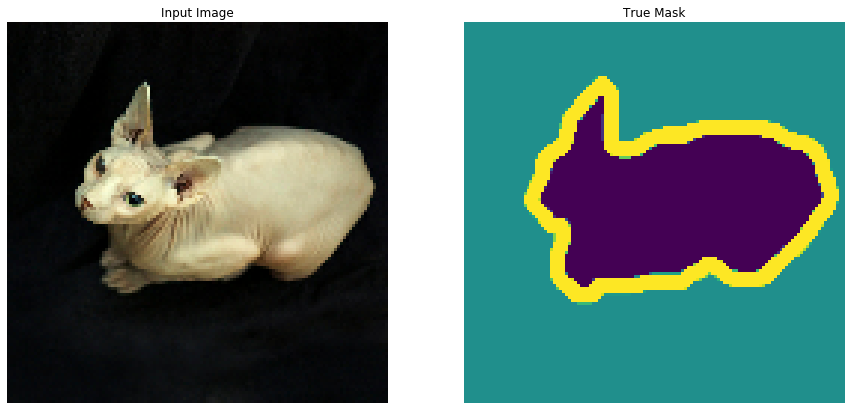

In [13]:
for image, mask in train.take(1):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

In [14]:
OUTPUT_CHANNELS = 3
#取出MobileNetV2預訓練模型
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False) 

#使用這幾層做運算層
layer_names = [
    'block_1_expand_relu',   
    'block_3_expand_relu',  
    'block_6_expand_relu',   
    'block_13_expand_relu', 
    'block_16_project',      
]
layers = [base_model.get_layer(name).output for name in layer_names]

#建立萃取特徵的模型
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)
down_stack.trainable = False #關閉GradientTapes的追蹤

9412608/9406464 [==============================] - 1s 0us/step


In [15]:
#進行skip connections前置作業，能保留更多的特徵訊息
#upsample(過濾器、大小)
#Conv2DTranspose => Batchnorm => Dropout => Relu
up_stack = [
    pix2pix.upsample(512, 3), 
    pix2pix.upsample(256, 3),  
    pix2pix.upsample(128, 3),  
    pix2pix.upsample(64, 3),  
]

In [16]:
def unet_model(output_channels): #建立U-Net概念的模型
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  x = inputs

  # 透過MobileNetV2對圖像縮減像素抽樣
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # 建立skip connections
  # 即每一層反捲積層的輸入都是：前一層的輸出+與該層對稱的卷積層的輸出
  for up, skip in zip(up_stack, skips):
    x = up(x)
    #透過Concatenate做連接
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # 模型最後一層為反卷積(Conv2DTranspose)
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [17]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
def create_mask(pred_mask):
  #取出預測後的資料點
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [19]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

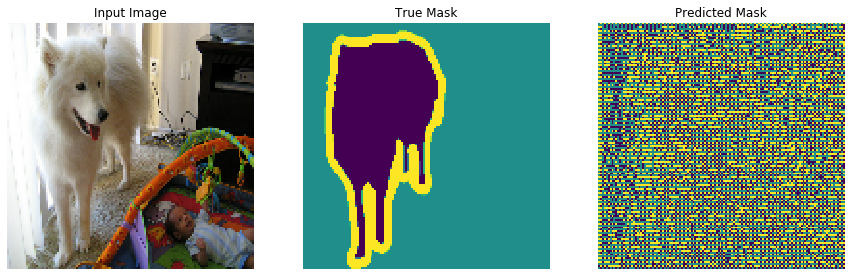

In [20]:
show_predictions(train_dataset,1)

In [21]:
#顯示每一次訓練的切割成果
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\n樣本預測結果的迭代數 {}\n'.format(epoch+1))

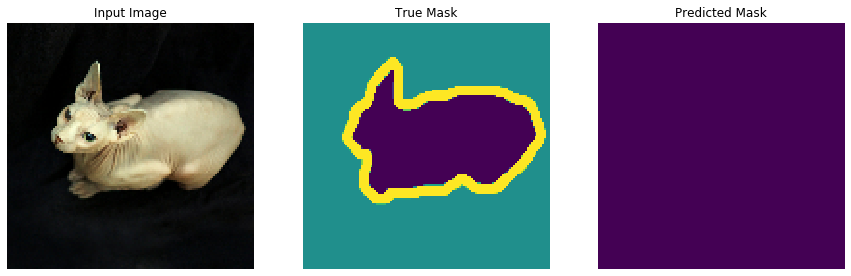


樣本預測結果的迭代數 9

57/57 [==============================] - 4s 74ms/step - loss: nan - accuracy: 0.1464 - val_loss: nan - val_accuracy: 0.3054
Epoch 10/20
42/57 [=====================>........] - ETA: 0s - loss: nan - accuracy: 0.1431

KeyboardInterrupt: 

In [22]:
EPOCHS = 20
VAL_SUBSPLITS = 7
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])


In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()


In [ ]:
show_predictions(test_dataset, 6)